# Проект "Принятие решений в бизнесе"

Компания, в которой мы работаем, хочет выйти на новый уровень, увеличить свою выручку. Для этого необходимо организовать определенный мероприятия, но пока непонятно какие. Поэтому руководство обратилось к нам - аналитикам.

У нас есть подготовленный список гипотез для увеличения выручки. Нам необходимо их приоритезировать - выяснить, какой путь выбрать компании. Для этого мы применим различные фреймворки и отсортируем гипотезы по убыванию приоритета.


Затем мы запустим А/В-тест и проанализируем его результаты. У нас будет 2 группы: А и В. Мы посмотрим, как складывалась конверсия, средний чек, выручка в каждой из групп. Изучим "сырые" данные, затем проверим их на аномалии, "очистим" от выбросов и посмотрим, что изменится.

Для проведения этой работы у нас есть 3 датафрейма: файл /datasets/hypothesis.csv содержит гипотезы, которые нам предстоит приоретизировать, /datasets/orders.csv — информацию о заказах, а /datasets/visitors.csv — информацию о количестве посетителей.



## Часть 1. Приоритизация гипотез.

### Предобработка данных.

Для начала подгрузим все библиотеки, которые могут нам пригодиться:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats as stats

Данные о гипотезах назовём data, данные о заказах - orders, о посещениях - visitors.

In [2]:
data = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

### Данные о гипотезах.

Выгрузим таблицу и информацию о ней:

In [3]:
pd.options.display.max_colwidth = 100
data.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Типы данных и названия столбцов удовлетворительные. Проверим таблицу на дубликаты.

In [5]:
data.duplicated().sum()

0

Явных дубликатов нет. Впринципе, понять, что обработка дополнительная не нужна - таблица маленькая. Можно продолжать работу с ней.

### Данные о заказах.

Выгрузим таблицу и информацию о ней:

In [6]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Посмотрим названия столбцов:

In [8]:
orders.columns.to_list()

['transactionId', 'visitorId', 'date', 'revenue', 'group']

Слишком громоздкие названия первых двух колонок предлагаю заменить на orderId и userId соответственно. Так же предлагаю заменить тип данных столбца date. Затем проверим на дубликаты.

In [9]:
orders.columns = ['orderId', 'userId', 'date', 'revenue', 'group']

In [10]:
orders['date'] = pd.to_datetime(orders['date'])

Проверим, что получилось:

In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   orderId  1197 non-null   int64         
 1   userId   1197 non-null   int64         
 2   date     1197 non-null   datetime64[ns]
 3   revenue  1197 non-null   int64         
 4   group    1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [12]:
orders.duplicated().sum()

0

Явных дубликатов нет. Проверим, есть ли пользователи, которые попали в обе группы:

In [13]:
def intersection_list(orders_A, orders_B): 
    return set(orders_A).intersection(orders_B) 
 
orders_A = orders.query('group == "A"')
orders_A = orders_A['userId'].drop_duplicates()
orders_B = orders.query('group == "B"')
orders_B = orders_B['userId'].drop_duplicates()
delete_list = intersection_list(orders_A, orders_B)
 
delete_list_count = len([item for item in delete_list])
 
display("количество пересекающихся пользователей:",delete_list_count)

'количество пересекающихся пользователей:'

58

Учитывая размер базы, а так же то, что задвоение само себя нивелирует, можно не тратить время на удаление этих дубликатов. Таблица готова к работе.

### Данные о посещениях.

Выгрузим таблицу и информацию о ней:

In [14]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [15]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Названия столбцов меня устраивают, предлагаю изменить тип данных в столбце date и проверить на дубликаты и пропуски:

In [16]:
visitors['date'] = pd.to_datetime(visitors['date'])

In [17]:
visitors.duplicated().sum()

0

In [18]:
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

In [19]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Дубликатов и пропусков нет. Теперь и эта таблица готова к работе.

Предлагаю посмотреть временные рамки тестирования, количество групп и размер групп по численности.

In [20]:
orders['group'].unique()

array(['B', 'A'], dtype=object)

In [21]:
orders.query('group == "A"')['group'].count()

557

In [22]:
orders.query('group == "B"')['group'].count()

640

In [23]:
orders['date'].max()

Timestamp('2019-08-31 00:00:00')

In [24]:
orders['date'].min()

Timestamp('2019-08-01 00:00:00')

Тест длился с 1 по 31 августа 2019 года - на протяжении месяца.Тест парный - 2 группы (А и В). Группа В больше группы А - это не очень хорошо, но мы будем работать с тем, что есть.

###  Применение фреймворк ICE для приоритизации гипотез. Сортировка их по убыванию приоритета.

Посчитаем ICE для гипотез. Добавим полученные значения ICE к существующей таблице. Новый столбец назовём ICE.
Выведем столбцы 'Hypothesis' и 'ICE', отсортированные по столбцу 'ICE'.

In [25]:
data['ICE'] = round((data['Impact']*data['Confidence'])/data['Efforts'], 2)
display(data[['Hypothesis','ICE']].sort_values(by='ICE', ascending=False))

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Наиболее перспективные гипотезы разместились под индексами 0,7 и 8.

###  Применение фреймворк RICE для приоритизации гипотез. Сортировка их по убыванию приоритета.

Посчитаем RICE для гипотез. Добавим полученные значения RICE к существующей таблице. Новый столбец назовем RICE. 
Выведите из получившейся таблицы столбцы 'Hypothesis' и 'RICE', отсортированные по столбцу 'RICE'. 

In [26]:
data['RICE'] = (data['Reach']*data['Impact']*data['Confidence'])/data['Efforts']
display(data[['Hypothesis','RICE']].sort_values(by='RICE', ascending=False))

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Теперь в лидерах гипотеза с индексом 7, за ней идут 2, 0 и 6.

###  Как и почему изменилась приоритизация гипотез при применении RICE вместо ICE

При применении RICE лидером среди гипотез стала гипотеза с индексом 7, как и в случае с применением ICE. Предлагаю вывести на экран всю таблицу и внимательно её изучить:

In [27]:
data

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3,7.00,56.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3,8.00,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2


ICE и RICE отличаются между собой. Фреймворк RICE реагирует в том числе и на количество пользователей, которых затронут изминения, изложенные в гипотезе. Эта информация отражается в параметре Reach. 
 
Параметр Reach у гипотезы с индексом 7 самый большой (10), за ней идут гипотезы 2 и 3 (8). Следовательно, охват пользователей у этих гипотез больше, что и оказывает влияние на приоретизацию. С учетом всего вышесказанного я бы выбрала для анализа именно гипотезу с индексом 7, так как не учитывать то, как много пользователей она затрагивает при всех прочих вводных, считаю нецелесообразным.

Вывод: мы провели первую часть работы - преоретизация гипотез. Для этого мы использовала фреймворки ICE и RICE. Результаты в обоих случаях не сильно противоречили друг другу по причине различий в параметрах. Я бы рекомендовала обязательно учитывать то, как много пользователей затрагивает гипотеза, поэтому мой фаворит - гипотеза с индексом 7. 

##  Часть 2. Анализ А/В-теста.

###   Построим график кумулятивной выручки по группам.

Чтобы построить графики, нужно собрать кумулятивные данные. Объявим датафрейм cumulativeData со столбцами:
date — дата;
group — группа A/B-теста (A или B);
orders — кумулятивное количество заказов на указанную дату в указанной группе;
buyers — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
revenue — кумулятивная выручка на указанную дату в указанной группе (средний чек);
visitors — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

In [28]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'orderId' : 'nunique', 'userId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5)) 

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


Построим графики кумулятивной выручки по дням и группам A/B-тестирования:

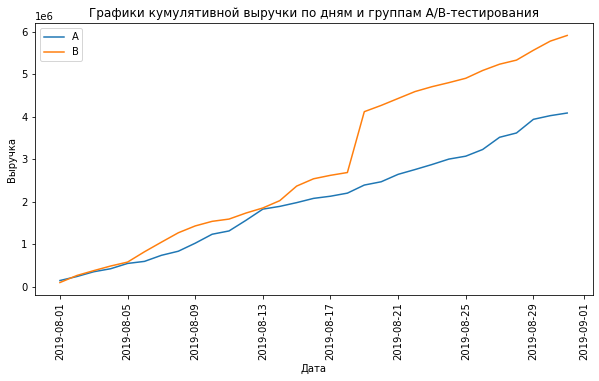

In [29]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
plt.figure(figsize=(10,5))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xticks(rotation=90)
plt.title('Графики кумулятивной выручки по дням и группам A/B-тестирования') 
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend()

plt.show()

Выручка почти равномерно увеличивается в течение всего теста. Однако графики выручки обеих групп в нескольких точках резко растут. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. 

### Построим график кумулятивного среднего чека по группам.

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:

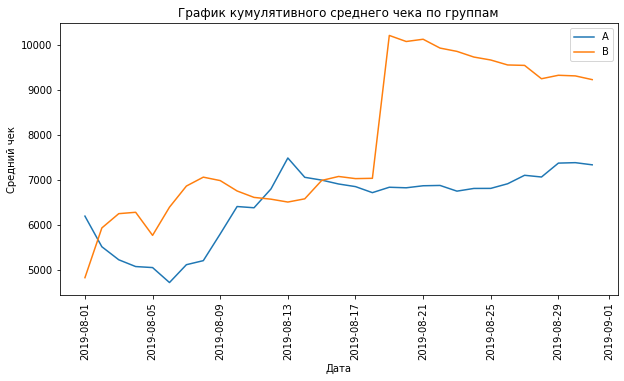

In [30]:
plt.figure(figsize=(10,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation=90)
plt.title('График кумулятивного среднего чека по группам') 
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.legend() 
plt.show()

Средний чек в обеих группах "лихорадило" на протяжении практически всего теста. После 17 августа произошел резкий скачек среднего чека в группе В (возможно большой заказ привел к тому, что нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне), затем спад и после 29 августа в обеих группах средний чек стабилизируется. 

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 

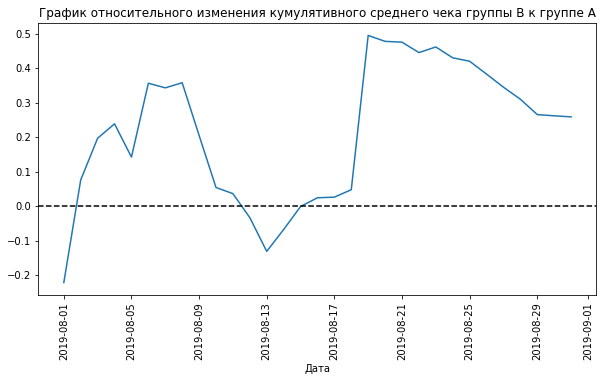

In [31]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(10,5))
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.xticks(rotation=90)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A') 
plt.xlabel('Дата')
plt.show()

В нескольких точках график различия между сегментами резко «скачет». Предполагаю, что спрятались крупные заказы и выбросы.

### Построим график кумулятивной конверсии по группам. 

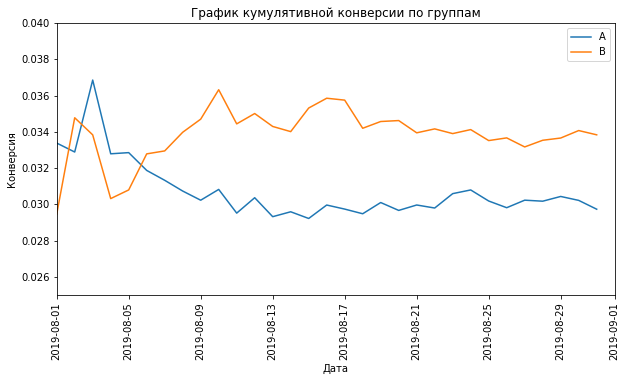

In [32]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
# строим графики
plt.figure(figsize=(10,5))

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.xticks(rotation=90)
plt.legend()
# задаем масштаб осей
plt.axis([dt.datetime.strptime('2019-08-01', '%Y-%m-%d'), dt.datetime.strptime('2019-09-01', '%Y-%m-%d'), 0.025, 0.040])

plt.title('График кумулятивной конверсии по группам') 
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.show()




В начале эксперимента обе конверсии совершили небольшой  скачек, затем с группе А конверсия пошла на убывание и с продолжением времени установилась, в то время как в группе В она подросла и тоже установилась.

### Построим график относительного изменения кумулятивной конверсии группы B к группе A.

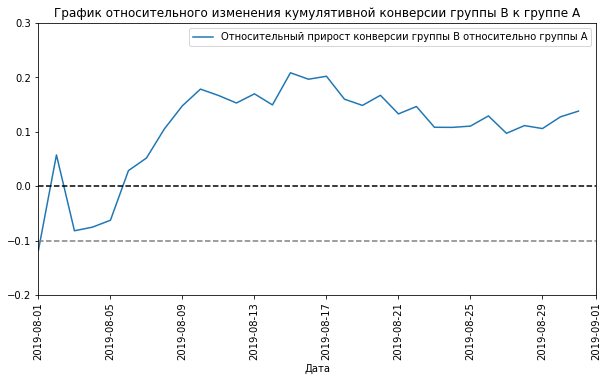

In [33]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(10,5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.xticks(rotation=90)
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axis([dt.datetime.strptime('2019-08-01', '%Y-%m-%d'), dt.datetime.strptime('2019-09-01', '%Y-%m-%d'), -0.2, 0.3])

plt.title('График относительного изменения кумулятивной конверсии группы B к группе A') 
plt.xlabel('Дата')

plt.show()


В начале теста группа B значительно проигрывала группе A, затем вырвалась вперёд и снова упала, затем начала стабильно опережать группу А и на продолжении теста оставалась в лидерах.

### Построим точечный график количества заказов по пользователям.

Для этого нам понадобится датасет orders. 

In [34]:
ordersByUsers = (
    orders.groupby('userId', as_index=False)
    .agg({'orderId': 'nunique'})
)

ordersByUsers.columns = ['userId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10)) 

          userId  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


Построим точечную диаграмму числа заказов на одного пользователя:

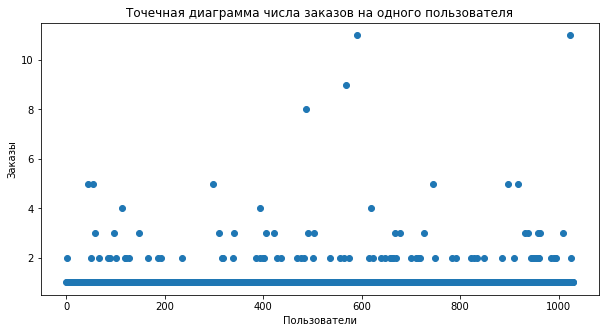

In [35]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.figure(figsize=(10,5))
plt.title('Точечная диаграмма числа заказов на одного пользователя') 
plt.xlabel('Пользователи')
plt.ylabel('Заказы')

plt.scatter(x_values, ordersByUsers['orders'])
plt.show()

Мы видим значительные выбросы. Хотелось бы взглянуть и на гисторгамму тоже:

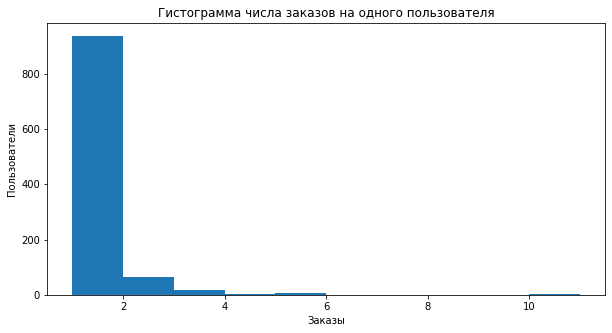

In [36]:
plt.figure(figsize=(10,5))
plt.hist(ordersByUsers['orders'])
plt.title('Гистограмма числа заказов на одного пользователя') 
plt.xlabel('Заказы')
plt.ylabel('Пользователи')
plt.show()

Большинство покупателей заказывают до 2-х раз. Много пользователей с 3-4 заказами. Их точная доля не ясна — непонятно, считать их аномалиями или нет.

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [37]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[2. 4.]


Теперь стало ясно, что не более 5% клиентов делали 2 заказа и не более 1% - 4. Разумно выбрать 2 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней. 

### Построим точечный график стоимостей заказов.

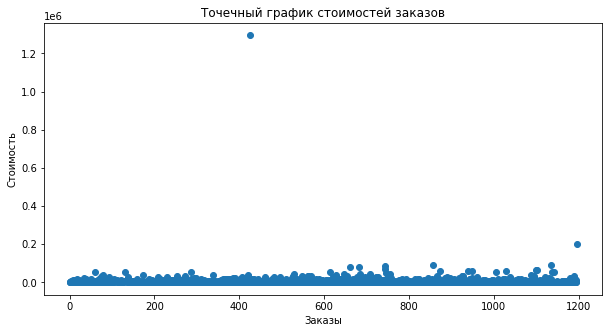

In [38]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(10,5))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечный график стоимостей заказов') 
plt.xlabel('Заказы')
plt.ylabel('Стоимость')
plt.show()

Мы видим 2 больших заказа (выброса). Теперь установим лимит для оси y и посмотрим информацию более детально.

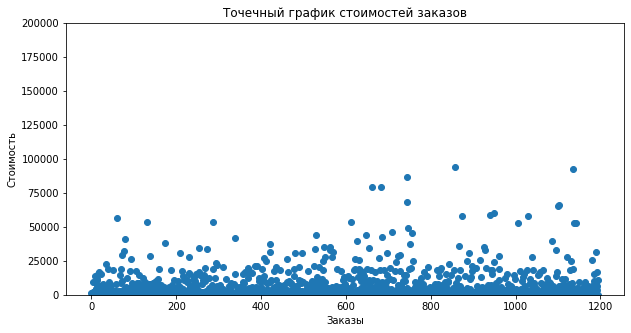

In [39]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(10,5))
plt.scatter(x_values, orders['revenue'])
plt.ylim([0, 200000])
plt.title('Точечный график стоимостей заказов') 
plt.xlabel('Заказы')
plt.ylabel('Стоимость')
plt.show()

Всё, как предполагали: есть немного дорогих заказов. По графику можно выбрать границу аномальных заказов между 25 000 и 50 000 рублей. Однако принято отсеивать от 1% до 5% наблюдений с крайними значениями.

### Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [40]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Получается, что всего 5% заказов имеют стоимость выше 28000, и всего 1% - более 58233.2. Здесь и будет проходить граница аномальных заказов.

### Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным. 

Сформулируем нулевую и альтернативную гипотезы:
- Н0: статистически значимых различий в конверсии между группами нет
- Н1:статистически значимые различия в конверсии между группами есть

Будем проверять сначала на "сырых" данных, потом "почистим" и проверим снова.

Мы будем проверять гипотезы критерием Манна-Уитни. В данных очевидно есть выбросы, поэтому для проверки мы выбрали этот критерий.

In [41]:
# Создадим переменные ordersByUsersA и ordersByUsersB со столбцами 'userId', 'orders'. 
# В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов и конверсию.
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']


ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

#подготовим выборки с количеством заказов на пользователя
visitors_daily_A = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_daily_A.columns = ['date', 'visitors_A']
 
visitors_daily_B = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_daily_B.columns = ['date', 'visitors_B']
 
 
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors_daily_A['visitors_A'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
 
sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors_daily_B['visitors_B'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
 
 
print('P-value:', "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print('Относительная разница в сравниваемых величинах:', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

P-value: 0.017
Относительная разница в сравниваемых величинах: 0.138


Первое число — p-value = 0.017 меньше 0.05. Значит, нулевую гипотезу отвергаем. Относительный проигрыш группы B равен 13,8% — второе число в выводе.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Сформулируем нулевую и альтернативную гипотезы:
Н0: статистически значимых различий в среднем чеке между группами нет
Н1:статистически значимые различия в среднем чеке между группами есть

Сначала будем проверять гипотезы на "сырых" данных, потом "почистим" и посмотрим, что измениться.

In [42]:
print('P-value:','{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительная разница в сравниваемых величинах:','{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

P-value: 0.729
Относительная разница в сравниваемых величинах: 0.259


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, относительный проигрыш группы B 25,9%. Посмотрим, что будет после "чистки" данных.

### Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. 

Узнаем, сколько всего аномальных пользователей:

In [43]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > np.percentile(ordersByUsers['orders'], 95)]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > np.percentile(ordersByUsers['orders'], 95)]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], 95)]['userId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0]) 

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: userId, dtype: int64
74


In [44]:
print('Процент потерь пользователей составил:', round(len(abnormalUsers.index.tolist()) / orders['userId'].nunique() * 100, 2), '%')

Процент потерь пользователей составил: 7.18 %


Всего 74 аномальных пользователей - это 7,18% пользователей.

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. Сначала подготовим выборки с конверсиями:

In [45]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                 visitors_daily_A['visitors_A'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors_daily_B['visitors_B'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [46]:
print('P-value:','{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительная разница в сравниваемых величинах:','{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

P-value: 0.013
Относительная разница в сравниваемых величинах: 0.173


P-value значительно меньше 0.05. Значит, стоит отвергнуть нулевую гипотезу и считать, что в конверсии есть различия. Впрочем, относительный проигрыш группы В - 17,3% 

P-value при "очистке" данных остался значительно ниже 0.05 - значит причины отвергать нулевую гипотезу есть, относительный проигрыш увеличился до 17,3% с 13,8%. Вот так изменилась ситуация после "очистки" данных.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

In [47]:
print(
    'P-value:',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    'Относительная разница в сравниваемых величинах:',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

P-value: 0.738
Относительная разница в сравниваемых величинах: -0.020


P-value сильно не изменился и остался больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, проигрыш группы B в меньшую сторону относительно группы A прилично увеличился превратился в небольшое лидирование в 2%, что подтверждает наш вывод.

После "очистки" данных p-value вырос с 0,729 до 0,947, что закрепило нас в уверенности в том, что нулевую гипотезу отвергать не стоит. Что касается отставания группы В, то теперь она вырвалась вперед (с 25,9% отставания до 2% лидирования) - вот как сильно были "засорены" данные.

### Примем решение по результатам теста.

Аномалий в данных было 7,18, и если говорить о среднем чеке, то p-value в "сырых" и "чистых" данных критически не изменился, а вот отставание группы В в 25,9% после проработки аномалий превратились в лидирование, хоть и небольшое - 1,6%. Можно прийти к выводу, что критических различий по среднему чеку между группами нет.

Что касается конверсий, то в "сырых" данных и в "очищенных" есть все причины отвергуть нулевую гипотезу. Различия между группами есть, и после "очистки" данных отставание группы В выросло с 13,8% до 17,3%.

График различия конверсии между группами сообщает, что в начале теста группа B значительно проигрывала группе A, затем вырвалась вперёд и снова упала, затем начала стабильно опережать группу А и на продолжении теста оставалась в лидерах. Т.о. график близок к стабилизации.

График различия среднего чека колеблется: он-то и позволил вам найти аномалии. Сделать из этого графика определённые выводы нельзя. Ожидать, что он стабилизаруется в случае продолжения теста предпосылок нет.

По всем вышеперечисленным причинам можно прийти к выводу, что статистически важных различий между группами не обнаружилось.
Предлагаю тест остановить и признать его успешным. Различия между группами в показателе конверсии на лицо - группа А в этом показателе проигрывает с отставанием в 17,3%.

